In [1]:
# this code is similar to the "crl tdr profiles.ipynb" file.
# but, it uses the newly created radial distance and rmw axes to plot the lidar data!
# hopefully more accurate to the TDR data?

In [2]:
# import modules

import numpy as np
import xarray as xr
import os
import sys
import matplotlib.pyplot as plt
import warnings
import math
import metpy.calc as mpcalc
from metpy.units import units

# old metadata is stored here
os.chdir("/Users/etmu9498/research/code/scripts/")
import tc_metadata

# new metadata is stored here
os.chdir("/Users/etmu9498/research/code/scripts-winter2023/cloud-top-height-stats")
import eyewall_metadata

os.chdir("/Users/etmu9498/research/code/scripts-winter2023")
import helper_fns_winter2023 as helper_fns


In [3]:
def plot_in_situ(crl_data, dist, lim0, lim1, plot_number=414):
    warnings.filterwarnings("ignore")

    fig = plt.gcf()
    ax1 = fig.add_subplot( plot_number)

    plt.xlabel( "Radial Distance (Km)")
    ax1.xaxis.grid( )
    ax1.yaxis.grid( )
    ax1.set_ylim([-10, 70])

    ax1.set_yticks([0,20,40,60])

    # actually plot everything!
    plt.plot( dist, crl_data.wind_speed[lim0:lim1], c='c', label='U (m/s)')
    plt.plot( dist, crl_data.w[lim0:lim1], c='y', label='W ( m/s)')
    plt.plot( dist, crl_data.fl_T[lim0:lim1], c='b', label=' T ( C)')

    leg = plt.legend(loc='upper right', framealpha=1.0, fontsize=14)
    leg.get_frame().set_linewidth( 1.5) 
    leg.get_frame().set_edgecolor('k')
    
    helper_fns.add_blank_colorbar() # color='gray')

    '''
    fig = plt.gcf()
    ax1 = fig.add_subplot( plot_number)

    ax1.set_ylabel( 'W (m/s)', c='y')
    ax1.set_xlabel( 'Distance from TC Center (km)')
    ax1.xaxis.grid( )
    ax1.yaxis.grid( )
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('U (m/s)', c='c')
    
    ax3 = ax1.twinx()
    ax3.set_ylabel( 'T ( C)', c='b')
    ax3.spines.right.set_position(("axes", 1.1))

    # set y limits to separate plots nicely
    ax2.set_ylim([-60, 70])
    ax1.set_ylim([-25, 30])
    ax3.set_ylim([0,70])
    
    # actually plot everything!
    ax2.plot( dist, crl_data.wind_speed[lim0:lim1], c='c', label='U (m/s)')
    ax1.plot( dist, crl_data.w[lim0:lim1], c='y', label='W ( m/s)')
    ax3.plot( dist, crl_data.fl_T[lim0:lim1], c='b', label=' T ( C)')

    # manually set y ticks?
    ax2.set_yticks([0,30,60])
    ax1.set_yticks([-20,-10,0,10,20,30])
    ax3.set_yticks([10,20,30])

    # add an empty colorbar to make everything fit in line
    helper_fns.add_blank_colorbar()# color='gray')

    warnings.filterwarnings("ignore")
    '''

In [4]:
### Helper functions for plotting crl data

# plotting power
def plot_power_ch1( crl_data, dist, lim0, lim1):
    # plot things
    plt.pcolormesh(  dist, crl_data.height / 1000, crl_data.P_ch1.transpose()[:, lim0:lim1], vmin = -30, vmax =-10)    
    plt.ylabel( 'Height (km)')    
    cbar = plt.colorbar()
    cbar.ax.set_ylabel( ylabel="CRL Return Power (dBz)")
    cbar.ax.tick_params(labelsize=20)
    plt.grid( 'on')
    ax = plt.gca()
    ax.set_facecolor('k')
    warnings.filterwarnings("default")
    
# plotting temperature
def plot_T( new_crl, dist, lim0, lim1):
    warnings.filterwarnings("ignore")
    color_map = plt.cm.get_cmap( "RdYlBu").reversed()

    plt.pcolormesh( dist, new_crl.height / 1000, new_crl.T.transpose()[:, lim0:lim1], cmap = color_map, vmin=5, vmax=25 )
    cbar = plt.colorbar()
    cbar.ax.set_ylabel( ylabel="CRL T ( C)")
    cbar.ax.tick_params(labelsize=20)
    plt.ylabel( 'Height (km)')
    plt.grid( 'on')
    ax = plt.gca()
    ax.set_facecolor('k')
    warnings.filterwarnings("default")


def plot_wvmr( crl_data, dist, lim0, lim1):
    # plot things
    plt.pcolormesh( dist, crl_data.height / 1000, crl_data.WVMR.transpose()[:, lim0:lim1], vmin = 8, vmax =18)
    cbar = plt.colorbar()
    cbar.ax.set_ylabel( ylabel="CRL WVMR (g/Kg)")
    cbar.ax.tick_params(labelsize=20)
    plt.ylabel( 'Height (km)')
    plt.grid( 'on')
    ax = plt.gca()
    ax.set_facecolor('k')

def plot_rh( crl_data, dist, lim0, lim1):
    
    # calculate rh first! 
    # find pressures at all crl data point locations
    rh = find_rh( crl_data, lim0, lim1)
    
    plt.pcolormesh( dist, crl_data.height/1000, rh.transpose(), cmap='Blues', vmin = 50, vmax =100)    
    cbar = plt.colorbar()
    cbar.ax.set_ylabel( ylabel="CRL RH (%)")
    cbar.ax.tick_params(labelsize=20)
    plt.ylabel( 'Height (km)')
    plt.grid( 'on')
    ax = plt.gca()
    ax.set_facecolor('k')

def plot_thetav(crl_data, dist, lim0, lim1):
    # setup
    p = find_pressure( crl_data, lim0, lim1)
    temp = crl_data.T[lim0:lim1, :].values
    mr = crl_data.WVMR[lim0:lim1, :].values / 1000
    color_map = plt.cm.get_cmap( "RdYlBu").reversed()

    # calculate potential temperature!!! woo!!
    p0 = 1000
    r_cp = .286
    rl = 0
    theta = (temp + 273.15 ) * ( p0 / p)**( r_cp)
    thetav = theta * ( 1 + .61 * ( mr / 1000) - rl  )

    # make the plot
    plt.pcolormesh( dist, crl_data.height/1000, thetav.transpose(), cmap=color_map, vmin = 300, vmax =320)    
    cbar = plt.colorbar()
    cbar.ax.set_ylabel( ylabel="CRL $\Theta_v$ (K)")
    cbar.ax.tick_params(labelsize=20)
    plt.ylabel( 'Height (km)')
    # plt.grid( 'on')
    ax = plt.gca()
    ax.set_facecolor('k')
    

In [33]:
### helper functions for plotting TDR data

def plot_tdr( tdr_data):
    warnings.filterwarnings("ignore")
    xaxis = tdr_data.distance
    
    # make plot
    color_map = plt.cm.get_cmap( "RdYlBu").reversed()

    # plot data
    # get rid of nans and resize array to get rid of overlapping data
    # also, no need to use .transpose() because that was already done when making the datasets!
    reflectivity = tdr_data.REFLECTIVITY[ :, 0:len( xaxis)]
    # refl = tdr_data.REFLECTIVITY[:, lat_no_nan_ind] # another way?
    plt.pcolormesh( xaxis, tdr_data.height, reflectivity, cmap = color_map, vmin = -10, vmax = 50 )

    print('plot created')
    
    # making things prettier
    cbar = plt.colorbar( )
    cbar.ax.set_ylabel( ylabel="TDR Reflectivity (dBZ)")
    cbar.ax.tick_params(labelsize=20)
    
    plt.ylabel( 'Height (Km)')
    plt.grid( 'on')
    warnings.filterwarnings("default")

    
# plot in situ p-3 heights over tdr data! kinda complicated because of axis sizing, etc
# also add velocity arrows!
def plotheight( tcdata, counter, crl_path, crl_name, tdr_data):
    in_situ_path = tcdata[ 'new_flight_data_path']
    in_situ_name = tc_metadata.choose_new_in_situ_name( tcdata['tc_name'], counter)

    # load in situ data
    os.chdir( in_situ_path)
    xr_in_situ = xr.open_dataset( in_situ_name)

    # add the subplot
    line = plt.plot( xr_in_situ['distance'].values, np.array( empty_str_helper( xr_in_situ['HT.d'].values)) / 1000, c='k', linewidth=4., label='P-3 Height')

    # creating velocity arrows!
    xaxis = tdr_data.distance
    # make plot
    ax = plt.gca()

    # get rid of nans and resize array to get rid of overlapping data
    uarrow = tdr_data.Radial_wind[ :, 0:len( xaxis)] # .transpose()
    warrow = tdr_data.Vertical_wind[ :, 0:len( xaxis)] # .transpose()
    
    color='k'
    arrow_spacing=5
    arrow_width=0.0015

    # slice down data to avoid arrow stacking + clutter
    wind_slice = (slice(None, None, arrow_spacing), slice(None, None, arrow_spacing)) # 7
    arrow = ax.quiver( tdr_data.distance[ wind_slice[0]], tdr_data.height[ wind_slice[1]],
        uarrow[wind_slice], # .m
        warrow[wind_slice], # .m
        pivot='mid', color=color,
        scale=1.0e-2, scale_units='inches', # 0.5e-6
        width= arrow_width) # .002
    
    testarrow = plt.scatter( 0, -100, c='k', marker=r'$\longrightarrow$', s=50, label='Velocity (m/s)' )
    
    leg = plt.legend(loc='upper right', framealpha=1.0, fontsize=14)
    leg.get_frame().set_linewidth( 1.5) 
    leg.get_frame().set_edgecolor('k')

    warnings.filterwarnings("default")


    
# turn all string values into floats
# this is a longer function to account for empty strings: turn those values into nans
def empty_str_helper( return_var):
    return_var_temp = np.zeros( len( return_var))
    count = 0
    for line_ind in range( len( return_var)):
        if return_var[ line_ind] == '':
            return_var_temp[line_ind] = np.nan
            count += 1
        else:
            return_var_temp[ line_ind] = float( return_var[ line_ind])
    return return_var_temp.tolist()

In [34]:
# helper function to make some of the radial distance values negative!
# make sure distance is an xarray input
# use lim0 and lim1 to constrain the distance axis: search for a min in there!
def flip_sign( crl_data, lim0, lim1, padding):
    
    look_inds = np.where(np.logical_and(crl_data.time > lim0, crl_data.time < lim1))[0]
    look_dist = crl_data['center_dist'][ look_inds]
    
    # find the index of the smallest distance: this is the center point
    # need to add the original look_inds distance to the array -> get back to starting point!
    centeri = np.argmin(look_dist.values) + look_inds[0]
    
    dists = crl_data['center_dist'].values
    
    # trim distances down to - padding to + padding (like -100 to +100)
    # do - values first
    lefti = centeri
    while True:
        # found the distance limit!
        if math.floor( dists[lefti]) == padding:
            break
        # continue case: iterate the index
        else:
            lefti -= 1
    # now search for + padding limits
    righti = centeri
    while True:
        if math.floor( dists[righti]) == padding:
            break
        else:
            righti += 1

    # finally trim the distances!!
    # make distances before centeri negative, and after positive
    newdists = - dists[lefti : centeri]
    newdists = newdists.tolist() + dists[centeri:righti+1].tolist()
    
    return np.array(newdists), lefti, righti+1
    
# helper function to get the eyewall limits for the crl data
# inputs: the date of the tc, and the dataset to use (ranges from 0 to 6)
def get_lims( date, dataset):
    lim_index = 0
    # load all new metadata
    metadata = eyewall_metadata.all_metadata()
    limits2021 = metadata['2021']['eyewall_limits'][date]
    
    # correct the dataset numbers depending on the date
    # 9/26 is already good- 0 to 2 works
    if date == "0926":
        lim_index = dataset
    # need to turn datasets 3 / 4 into 0 / 1 for proper indexing
    elif date == '0927':
        lim_index = dataset - 3
    # need to turn datasets 5 / 6 into 0 / 1
    elif date == '0929':
        lim_index = dataset - 5
        
    # return the correct eyewall limits!
    return limits2021[lim_index][0], limits2021[lim_index][1]

In [35]:
# scripts used above to find pressure, relative humidity, and theta fields!

# find a 2D pressure field for crl data
def find_pressure( crl_data, lim0, lim1, slope = -10.257,):
    
    # trim vars down to lim0 to lim1 for faster processing
    temp = crl_data.T[lim0:lim1, :]    
    power = crl_data.P_ch1[lim0:lim1, :]
    psurf = crl_data.fl_psurf[lim0:lim1]
    height = crl_data.p3_height[lim0:lim1]

    # make a new matrix to hold pressure values; the same size as temp
    new_matrix=np.empty([ np.size( temp, 0), np.size( temp, 1)])
    warnings.filterwarnings("ignore")
    print( 'creating pressure matrix')

    # do this for every timestep!
    for crl_ind in range( np.shape( temp)[0]):

        # get the surface pressure at the closest timestep
        psurfi = psurf[ crl_ind]

        # make an equation relating pressure to height ( y = 0m here)
        yint = - ( slope * psurfi)

        # get current p3 height
        heighti = height[ crl_ind]

        # find pressure at this height using the equation above!
        # height is defined in the if statement above
        ptop = ( heighti - yint) / slope

        # create a vertical pressure profile for this index
        pcolumn = np.linspace( ptop, psurfi, np.shape( temp)[1])
        new_matrix[ crl_ind, :] = pcolumn
        
        
    warnings.filterwarnings("default")
    return new_matrix

def find_rh( crl_data, lim0, lim1):
    p = find_pressure( crl_data, lim0, lim1)
    temp = crl_data.T[lim0:lim1, :].values
    mr = crl_data.WVMR[lim0:lim1, :].values / 1000
    
    # save rh values here
    new_matrix=np.empty([np.size(p, 0), np.size(p, 1)])

    
    # test: find rh for one point
    '''
    xi = 300
    heighti = 500
    print( p[xi, heighti])
    print( temp[xi, heighti])
    print( mr[xi, heighti])
    rh = mpcalc.relative_humidity_from_mixing_ratio( p[xi, heighti] * units.hPa, temp[xi, heighti] * units.degC, mr[xi, heighti]).to('percent')
    print(rh)
    '''
    
    # do this for every height row
    for rowi in range( np.shape(p)[1]):
        # find the relative humidity for this height row
        rh_row = mpcalc.relative_humidity_from_mixing_ratio( p[:, rowi] * units.hPa, temp[:, rowi] * units.degC, mr[:, rowi]).to('percent')

        # print(np.shape(rh_row))
        # print(rh_row)

        # only keep rh values between 0-100%
        # rh_row[np.where( np.logical_and( rh_row>=0, rh_row<=100))] = np.nan

        # print(np.shape(rh_row))
        # print(rh_row)
        
        # add the new height row!
        new_matrix[:, rowi] = rh_row
        
    return new_matrix

creating figure
plot created
tdr plot added
crl wv plot added


C:\Users\etmu9498\AppData\Local\Temp\ipykernel_8268\3649208550.py:34: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh( dist, crl_data.height / 1000, crl_data.WVMR.transpose()[:, lim0:lim1], vmin = 8, vmax =18)


crl temp plot added
fl plots added
figure saved


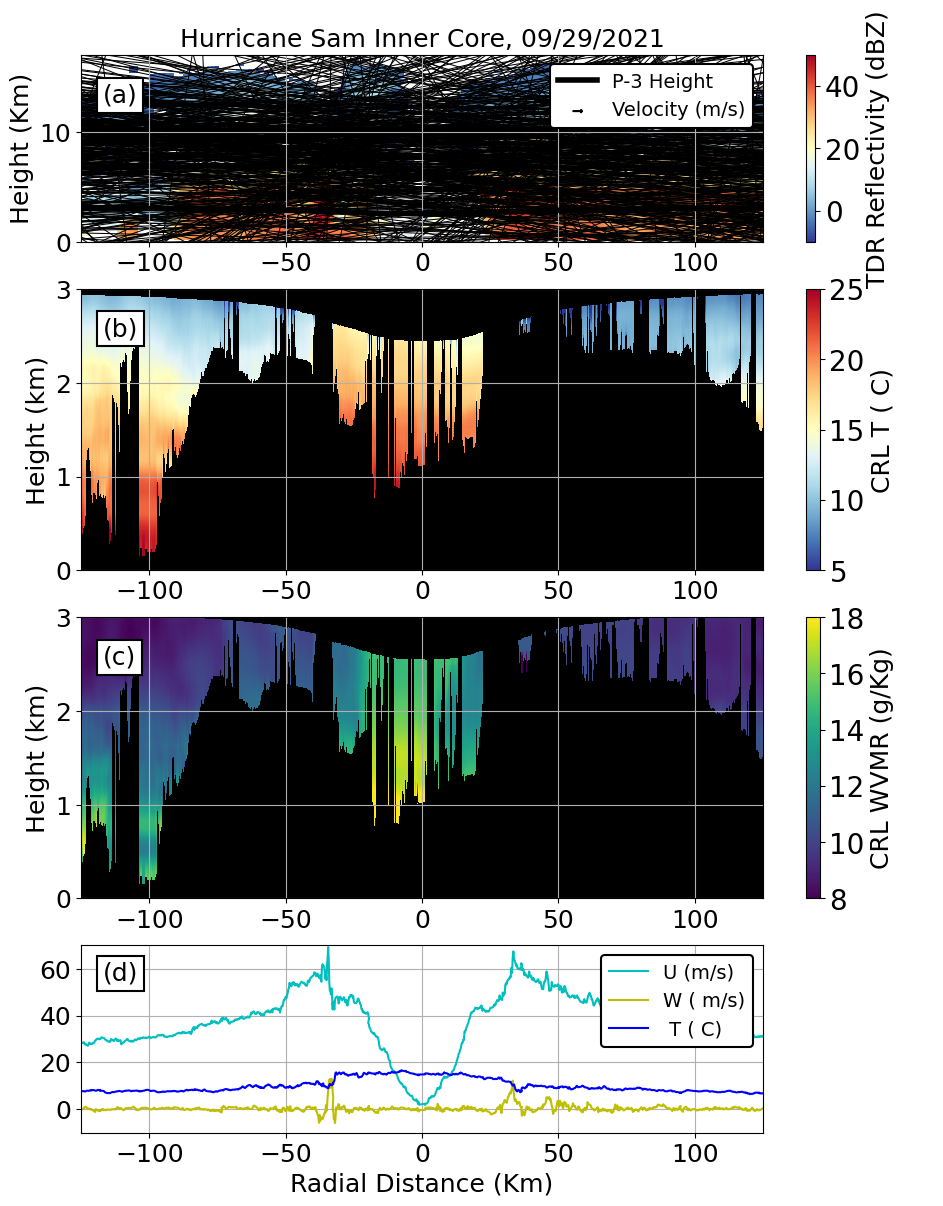

In [36]:
# make a nice tdr and crl figure for the selected date!

# metdata for the tdr figure
tcname = 'sam'
metadata = tc_metadata.all_data( tcname)
dataset = 5
padding = 125 # amount of space on each side of tc center
xtxt = -117

if dataset == 0:
    crl_new_name = "P3_20210926H1_processed.nc"
    tdr_new_name = "tdr_combined_sam_210926H1_2237.nc"
elif dataset == 1:
    crl_new_name = "P3_20210926H1_processed.nc"
    tdr_new_name = "tdr_combined_sam_210926H1_2350.nc"
elif dataset == 2:
    crl_new_name = "P3_20210926H1_processed.nc"
    tdr_new_name = "tdr_combined_sam_210926H1_2457.nc"
    
elif dataset == 3:
    crl_new_name = "P3_20210927H1_processed.nc"
    tdr_new_name = "tdr_combined_sam_210927H1_2320.nc"
elif dataset == 4:
    crl_new_name = "P3_20210927H1_processed.nc"
    tdr_new_name = "tdr_combined_sam_210927H1_2433.nc"

elif dataset == 5:
    crl_new_name = "P3_20210929H2_processed.nc"
    tdr_new_name = "tdr_combined_sam_210929H2_2137.nc"
elif dataset == 6:
    crl_new_name = "P3_20210929H2_processed.nc"
    tdr_new_name = "tdr_combined_sam_210929H2_2249.nc"

date = crl_new_name[7:11]

# load new crl and tdr data here!
crl_path = "/Users/etmu9498/research/data/crl-all-data-processed/2021/"
os.chdir(crl_path)
crl_data = xr.open_dataset(crl_new_name)
tdr_path = "/Users/etmu9498/research/data/tdr-one-pass/2021/sam/"
os.chdir(tdr_path)
tdr_data = xr.open_dataset(tdr_new_name)

# need to find limits for this data, too
lim0, lim1 = get_lims(date, dataset)

# find the corrected distance axis!
dist, lefti, righti = flip_sign( crl_data, lim0, lim1, padding)



# initialize figure
warnings.filterwarnings("ignore")
fig1 = plt.subplots(4, 1, gridspec_kw={'height_ratios': [1, 1.5, 1.5, 1]}, figsize=(11, 14)) # , facecolor='w')
helper_fns.change_font_sizes(small=18, medium=18)

print('creating figure')

# create tdr plot
plt.subplot( 411)
plt.title( "Hurricane Sam Inner Core, " + date[0:2] + "/" + date[2:4] + "/2021", loc='center')
plot_tdr( tdr_data)
plt.xlim( [ - padding, padding])
plt.ylim( [0, 17])
txt = plt.text(xtxt, 12.7, "(a)", fontsize=18)
txt.set_bbox(dict(facecolor='w', alpha=1.0, edgecolor='k', linewidth=1.5))
print('tdr plot added')

plotheight( metadata, dataset, crl_path, crl_new_name, tdr_data)


# plot crl water vapor with in situ distance axis
plt.subplot(412)
plot_T( crl_data, dist, lefti, righti) # use this local function, not the one found in make_plots_new_heights
plt.xlim( [ - padding, padding])
plt.ylim( [ 0, 3])
txt = plt.text(xtxt, 2.5, "(b)", fontsize=18)
txt.set_bbox(dict(facecolor='w', alpha=1.0, edgecolor='k', linewidth=1.5))

print( 'crl wv plot added')


# plot crl temp with in situ distance axis
plt.subplot(413)
plot_wvmr( crl_data, dist, lefti, righti) # use this local function, not the one found in make_plots_new_heights
plt.xlim( [ - padding, padding])
plt.ylim( [ 0, 3])
txt = plt.text(xtxt, 2.5, "(c)", fontsize=18)
txt.set_bbox(dict(facecolor='w', alpha=1.0, edgecolor='k', linewidth=1.5))
print( 'crl temp plot added')


# plot flight level data
plt.subplot(414)
plt.grid(False)
plt.axis('off')
plot_in_situ(crl_data, dist, lefti, righti)
plt.xlim( [ - padding, padding])
txt = plt.text(xtxt, 55, "(d)", fontsize=18)
txt.set_bbox(dict(facecolor='w', alpha=1.0, edgecolor='k', linewidth=1.5))
print( 'fl plots added')

os.chdir( "/Users/etmu9498/research-private/eye-cloud-paper/")
# plt.savefig( "figure-1-panels-" + date + '-' + str(dataset) + ".png", dpi=200, bbox_inches='tight')

print( 'figure saved')
